In [1]:
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
from keras import optimizers
import keras
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt    
%matplotlib inline
import numpy as np
import os
import glob
import cv2

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:

! mkdir train_dir
! unzip '/content/gdrive/MyDrive/Training_Kick.zip' -d train_dir

mkdir: cannot create directory ‘train_dir’: File exists
Archive:  /content/gdrive/MyDrive/Training_Kick.zip
replace train_dir/Training_Kick/kick_0.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
video_directory="/content/train_dir/Training_Kick"
videos=os.listdir(video_directory)
label=[]
for i in videos:
    if "other_" in i:
        label.append(0)
    else: 
        label.append(1)
       
videos=pd.DataFrame(videos,label).reset_index()
videos.columns=["labels","video_name"]


In [3]:
# put 40% videos for validation and 60% for training
other=videos.loc[videos["labels"]==0,]
kick=videos.loc[videos["labels"]==1,]

other_range=np.arange(len(other))
kick_range=np.arange(len(kick))
np.random.seed(8)
np.random.shuffle(other_range)
np.random.shuffle(kick_range)

kick=kick.iloc[kick_range,]
other=other.iloc[other_range,]

train_kick=kick.iloc[:60,]
train_other=other.iloc[:48,]
valid_kick=kick.iloc[60:,]
valid_other=other.iloc[48:,]

train_set=train_kick.append(train_other)
valid_set=valid_kick.append(valid_other)

train_set=train_set.reset_index().drop("index",axis=1)
valid_set=valid_set.reset_index().drop("index",axis=1)
train_set

,labels,video_name
0,1,kick_10.avi
1,1,kick_30.avi
2,1,kick_19.avi
3,1,kick_20.avi
4,1,kick_37.avi
...,...,...
103,0,other_54.avi
104,0,other_41.avi
105,0,other_59.avi
106,0,other_53.avi


In [4]:

train_label=train_set["labels"]
valid_label=valid_set["labels"]
print(len(valid_set))
print(len(train_label))


72
108


In [ ]:
!rm -rf frame_valid

In [5]:
# ! mkdir frame_dir
! mkdir frame_train
! mkdir frame_valid

mkdir: cannot create directory ‘frame_train’: File exists
mkdir: cannot create directory ‘frame_valid’: File exists


In [6]:
#fuction gets the video and save the frames of videos to .jpg format
def get_frames(dataset, dest_path):
    for i in np.arange(len(dataset)):
          video_name=dataset.video_name[i]
          video_path=os.path.join(video_directory,video_name)
          file_name = video_path.split('.')[0].split('/')[-1]
          cap= cv2.VideoCapture(video_path)
          total_frames = int(cap.get(7))
          frame_rate = cap.get(5)
          # print(file_name,total_frames,frame_rate)
          frame_distance = total_frames//10
          
          count=0
          frame_count=0
          for i in range (total_frames): #iterating over all the frames of the video.
              ret, frame = cap.read()
              if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
                  frame = f_prev
              elif ret==True:
                  f_prev =frame
              frame_count +=1
              if ((frame_count ==(frame_distance)) and (count<10)):
                  frame_count = 0
                  cv2.imwrite(dest_path+'/'+file_name+'_'+ str(count)+".jpg",frame)
                  count +=1
    cap.release()
    return print("All frames written in the  "+dest_path)

In [7]:
frame_train='/content/frame_train'
frame_valid='/content/frame_valid'
get_frames(train_set,frame_train)
get_frames(valid_set,frame_valid)
print(len(os.listdir(frame_valid)))

All frames written in the  /content/frame_train
All frames written in the  /content/frame_valid
720


In [8]:
img_high=220
img_width=220
frame_no_video=10

In [9]:
def get_train_data(file_name):
    training = []
    frames_to_select=[]
    for i , filename in enumerate(glob.glob(file_name)):

        image = cv2.imread(filename)
        img = cv2.resize(image, dsize=(img_high,img_width), interpolation=cv2.INTER_CUBIC)
        # normalizing the pixel value
        img = img/255
        training.append(img)
    return training


In [10]:
training = get_train_data(frame_train + '/*.jpg')
validation = get_train_data(frame_valid + '/*.jpg')

In [11]:
x_train=np.array(training)
x_valid=np.array(validation)
y_train= np.array(train_label)
y_valid=np.array(valid_label)

In [12]:
x_train=x_train.reshape(x_train.shape[0]//10,10,220,220, 3)
x_valid=x_valid.reshape(x_valid.shape[0]//10,10,220, 220, 3)
x_train.shape
x_valid.shape
y_valid.shape

(72,)

In [13]:
#3D CNN
input_model=Input(shape=(10,220,220,3))
layer=Conv3D(64,(3,3,3),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)

layer=Conv3D(64,(3,3,3),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Dropout(0.3)(layer)

layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.3)(layer)
layer=Dense(64,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model=Model(input_model,layer_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 220, 220, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 218, 218, 64)   5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 109, 109, 64)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 109, 109, 64)   256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 2, 107, 107, 64)   110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 53, 53, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 53, 53, 64)     256   

In [14]:
callbacks_model=[keras.callbacks.EarlyStopping(
               monitor='acc',patience=10),
               keras.callbacks.ModelCheckpoint(
               filepath= "/content/gdrive/MyDrive/model10.h5" ,
               monitor='val_loss',
               save_best_only=True),]

model.compile(optimizer=optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

history=model.fit(x_train,y_train,batch_size=5,epochs=10,
               validation_data=(x_valid,y_valid),callbacks=callbacks_model)  

Epoch 1/10
22/22 [==============================] - 16s 253ms/step - loss: 7.8156 - acc: 0.5260 - val_loss: 5.6222 - val_acc: 0.4444
Epoch 2/10
22/22 [==============================] - 4s 183ms/step - loss: 7.6933 - acc: 0.5956 - val_loss: 1.4119 - val_acc: 0.5278
Epoch 3/10
22/22 [==============================] - 4s 183ms/step - loss: 6.3632 - acc: 0.7998 - val_loss: 3.5288 - val_acc: 0.5556
Epoch 4/10
22/22 [==============================] - 4s 185ms/step - loss: 6.4215 - acc: 0.7594 - val_loss: 13.2913 - val_acc: 0.4444
Epoch 5/10
22/22 [==============================] - 4s 187ms/step - loss: 6.7932 - acc: 0.8487 - val_loss: 6.1686 - val_acc: 0.5417
Epoch 6/10
22/22 [==============================] - 4s 185ms/step - loss: 2.3796 - acc: 0.9066 - val_loss: 12.2180 - val_acc: 0.5417
Epoch 7/10
22/22 [==============================] - 4s 185ms/step - loss: 1.9863 - acc: 0.9104 - val_loss: 10.3421 - val_acc: 0.5694
Epoch 8/10
22/22 [==============================] - 4s 186ms/step - loss

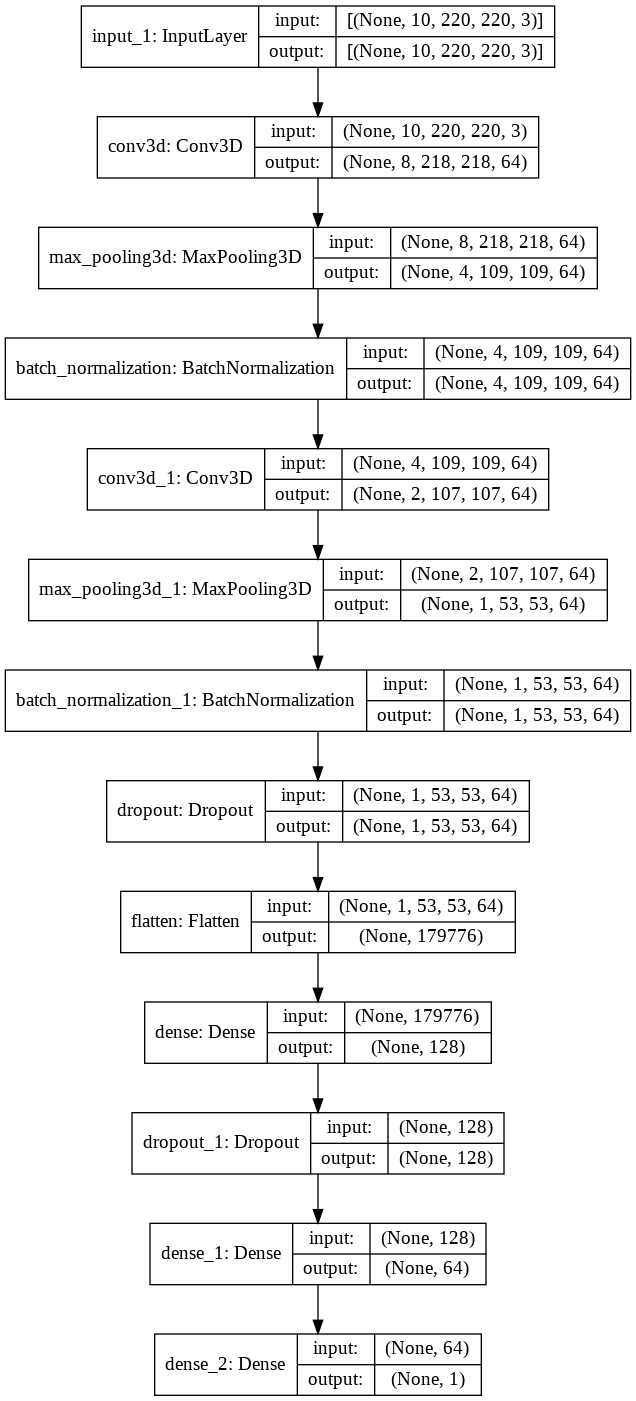

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

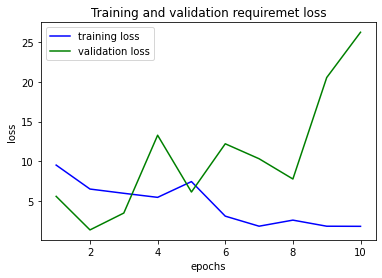

In [16]:
epochs = range(1,11)
plt.plot(epochs, history.history['loss'], 'b', label = 'training loss')
plt.plot(epochs, history.history['val_loss'], 'g', label = 'validation loss')
plt.title('Training and validation requiremet loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [17]:
! mkdir test_dir
! unzip '/content/gdrive/MyDrive/Test_Kick.zip' -d test_dir

mkdir: cannot create directory ‘test_dir’: File exists
Archive:  /content/gdrive/MyDrive/Test_Kick.zip
replace test_dir/Test_Kick/kick_0.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
! mkdir frames_test

mkdir: cannot create directory ‘frames_test’: File exists


In [18]:
video_directory='/content/test_dir/Test_Kick'
frames_test='/content/frames_test'

In [19]:
#save the frames of all videos
videos=os.listdir(video_directory)
test_label=[]
for i in videos:
    if "other_" in i:
        test_label.append(0)
    else: 
        test_label.append(1)
print(len(test_label))

videos=pd.DataFrame(videos,test_label).reset_index()
videos.columns=["test_label","video_name"]

other=videos.loc[videos["test_label"]==0,]
waiving=videos.loc[videos["test_label"]==1,]

test_set=other.append(waiving)

test_set

54


,test_label,video_name
2,0,other_15.avi
9,0,other_5.avi
10,0,other_17.avi
13,0,other_23.avi
14,0,other_21.avi
17,0,other_3.avi
23,0,other_14.avi
26,0,other_4.avi
27,0,other_10.avi
28,0,other_11.avi


In [20]:
#save the frames of all videos
get_frames(test_set,frames_test)

All frames written in the  /content/frames_test


In [21]:
testing = get_train_data(frames_test + '/*.jpg')

In [22]:
X_test = np.array(testing)
y_test = np.array(test_label)
X_test=X_test.reshape(X_test.shape[0]//10,10,220, 220, 3)
print(X_test.shape)
print(y_test.shape)

(54, 10, 220, 220, 3)
(54,)


In [23]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 4s 1s/step - loss: 28.9183 - acc: 0.5556
acc: 55.56%
